# Classification

In [67]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [68]:
X = mnist["data"]
y = mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


The dataset contains 70_000 different numbers between 0-9 and has 784 columns. This represent the intensity of each pixel, ranging from 0 - 255, and the 784 columns represents the 28x28 format of the image

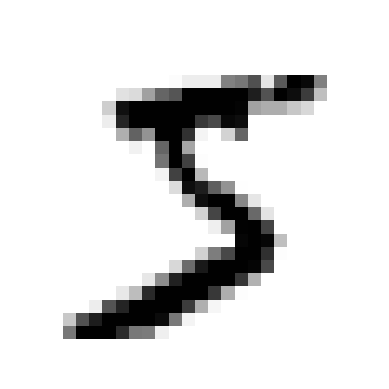

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values #This is done because X is a pandas Df
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

The image looks like a 5

In [70]:
y=y.astype(int)
y[0]

5

The image is indeed a 5

## Train test split

In [71]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

In this case the binary classifier will determine wether a number is a 5 or not

In [72]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [73]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [74]:
sgd_clf.predict([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Implementing cross-validation

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [76]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [77]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)

In [78]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [79]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [80]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [81]:
y_train_prefect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Recall and precision

In [82]:
from sklearn.metrics import recall_score, precision_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

## F1 score

In [83]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision/Recall tradeoff

In [84]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [85]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

With a low treshold, almost any value can belong to the positive class

In [86]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

With a high threshold, even positive values may be detected as false

In [87]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [88]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

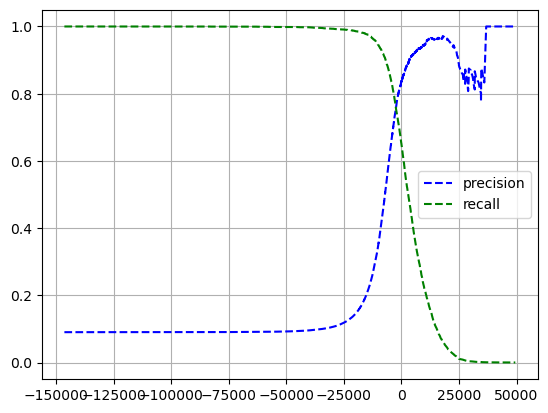

In [89]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1],  "g--", label="recall")
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

This graph shows the relationship between precision and recall with various thresholds

In [90]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f"Precision: {precision_score(y_train_5, y_train_pred_90)}, Recall: {recall_score(y_train_5, y_train_pred_90)}")

Precision: 0.9000345901072293, Recall: 0.4799852425751706


With the right threshold, you can obtain any desired precision

### ROC Curve

In [91]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds, = roc_curve(y_train_5, y_scores)

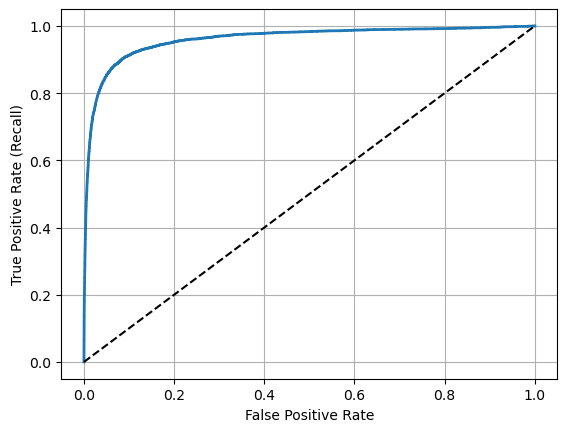

In [92]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    
plot_roc_curve(fpr, tpr)

In [93]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier

In [94]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [95]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

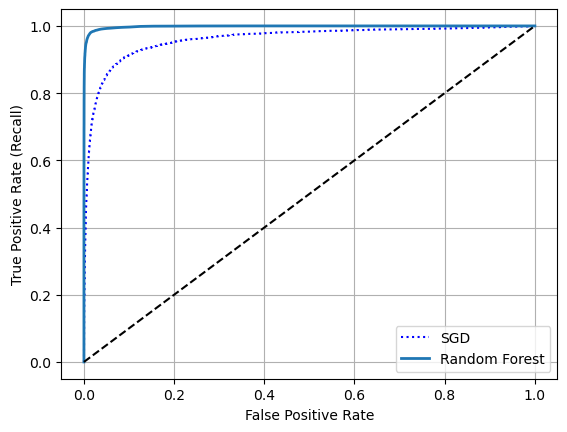

In [96]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [97]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [98]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3])

In [99]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

This is an array that represents the value of the given digit to belong to each class 0-9

In [100]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5])

This sklearn class lets us run a one vs one classifier

In [101]:
len(ovo_clf.estimators_)

45

In [102]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5])

In [103]:
forest_clf.predict_proba([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

This are the assigned probabilities `some digit` belongs to each class

In [104]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [106]:
from sklearn.metrics import confusion_matrix

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

KeyboardInterrupt: 

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [ ]:
import matplotlib.pyplot as plt

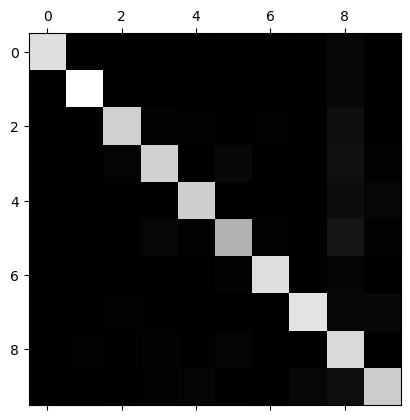

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

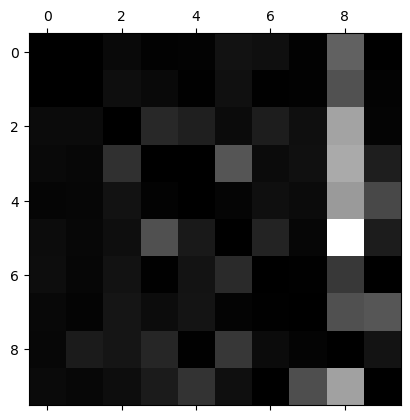

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") #Different averages do different things with the output classes

0.9764102655606048

## Multioutput classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mode = X_test + noise 

y_train_mod = X_train
y_test_mod = X_test

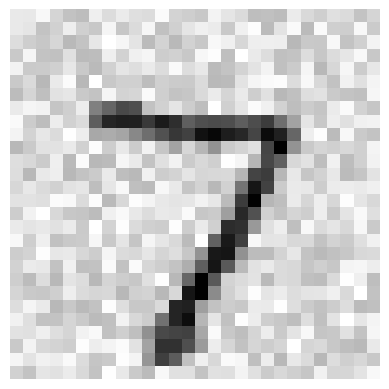

In [ ]:
some_digit_mod = X_test_mode.iloc[0].values #This is done because X is a pandas Df
some_digit_mod_image = some_digit_mod.reshape(28,28)

plt.imshow(some_digit_mod_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mode.iloc[6000]])

c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


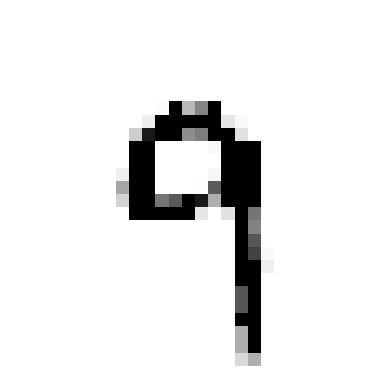

In [66]:
clean_digit_image = clean_digit.reshape(28,28)

plt.imshow(clean_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()